<a href="https://colab.research.google.com/github/flying-bear/kompluxternaya/blob/master/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment 5
Build CNN model for sentiment analysis (binary classification) of IMDB Reviews (https://www.kaggle.com/utathya/imdb-review-dataset). You can use data with label="unsup" for pretraining of embeddings. Here you are forbidden to use test dataset for pretraining of embeddings.
Your quality metric is accuracy score on test dataset. Look at "type" column for train/test split.
You can use pretrained embeddings from external sources.
You have to provide data for trials with different hyperparameter values.

You have to beat following baselines:

[3 points] acc = 0.75

[5 points] acc = 0.8

[8 points] acc = 0.9

[2 points] for using unsupervised data

In [0]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn import metrics
from tqdm import tqdm

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator



SEED = 42
np.random.seed(SEED)

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tag_map['S'] = wn.ADJ_SAT

lmtzr = WordNetLemmatizer()

def lemmatize(tokens):
  lemmas = []
  for token, tag in pos_tag(tokens):
      lemmas.append(lmtzr.lemmatize(token, tag_map[tag[0]]))
  return lemmas

In [0]:
spacy_en = spacy.load('en')
def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [0]:
def lemmatizer(text):
  return lemmatize(tokenizer(text))

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
csv_path = "/content/drive/My Drive/studies/HSE/prog/kompluxternaya/imdb_master.csv"

In [0]:
data = pd.read_csv(csv_path, index_col=0, encoding='iso-8859-1')
data = data.drop(["file"], axis=1)

In [0]:
test_df = data.loc[data["type"] == "test"].drop(["type"], axis=1)
train_df = data.loc[data["type"] == "train"].drop(["type"], axis=1)
unsup_texts = list(train_df.loc[train_df["label"] == "unsup", "review"])
train_df = train_df.loc[train_df["label"] != "unsup"]

In [0]:
train_df.to_csv("imdb_train.csv", encoding="utf-8")
test_df.to_csv("imdb_test.csv", encoding="utf-8")
data.to_csv("imdb_data.csv", encoding="utf-8")

In [12]:
train_df

,review,label
25000,Story of a man who has unnatural feelings for ...,neg
25001,Airport '77 starts as a brand new luxury 747 p...,neg
25002,This film lacked something I couldn't put my f...,neg
25003,"Sorry everyone,,, I know this is supposed to b...",neg
25004,When I was little my parents took me along to ...,neg
...,...,...
49995,"Seeing as the vote average was pretty low, and...",pos
49996,"The plot had some wretched, unbelievable twist...",pos
49997,I am amazed at how this movie(and most others ...,pos
49998,A Christmas Together actually came before my t...,pos


In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, dropout_rate=0.2):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.dout = nn.Dropout(dropout_rate)

        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 2)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dout(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [0]:
def train_epoch(model, optimizer, criterion, train_iterator, n_epoch):
    model.train()
    train_losses = []
    
    progress_bar = tqdm(total=len(train_iterator.dataset), desc=f"Epoch {n_epoch + 1}")
    
    model.train()
    
    for el in train_iterator:
        x = el.review[0]  # first is embedded thing, second is ids of reveiws?
        y = el.label
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    return train_losses

In [0]:
def evaluate_epoch(model, criterion, valid_iterator):
  model.eval()
  val_losses = []
  val_targets = []
  val_pred_class = []
  for el in valid_iterator:
      x = el.review[0]
      y = el.label
      x = x.to(device)

      with tt.no_grad():

          pred = model(x)

          pred = pred.cpu()

          val_targets.append(y.numpy())
          val_pred_class.append(np.argmax(pred, axis=1))

          loss = criterion(pred, y)

          val_losses.append(loss.item())
      
  mean_val_loss = np.mean(val_losses)

  val_targets = np.concatenate(val_targets).squeeze()
  val_pred_class = np.concatenate(val_pred_class).squeeze()

  acc = metrics.accuracy_score(val_targets, val_pred_class)
  return mean_val_loss, acc

In [0]:
def train_my_model(model, train_iterator, valid_iterator, criterion, optimizer, epochs = 10, best_val_loss=10., early=True):
  model = model.to(device)
  criterion = criterion.to(device)
  val_acc = []
  for n_epoch in range(epochs):
      
      train_losses = train_epoch(model, optimizer, criterion, train_iterator, n_epoch)
      
      mean_val_loss, acc = evaluate_epoch(model, criterion, valid_iterator)
      val_acc.append(acc)
      
      print()
      print(f"Losses: train - {np.mean(train_losses):.3f}, validation - {mean_val_loss:.3f}")

      print(f"Validation accuracy - {acc:.3f}")
          
      # Early stopping:
      if early:
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
        else:
            print("Early stopping")
            break
  return train_losses, val_acc

In [0]:
def plot_loss(losses, step=1):
  plt.figure(figsize=(14, 12))
  plt.plot(losses[::step])
  plt.grid()
  plt.title('Training process')
  plt.xlabel('Iterations')
  plt.ylabel('Loss function');

In [0]:
def test_model(model, test_iterator):
  model.eval()
  test_targets = []
  test_pred_class = []
  for el in tqdm(test_iterator, desc='test'):
      x = el.review[0]
      y = el.label
      x = x.to(device)

      with tt.no_grad():

          pred = model(x)

          pred = pred.cpu()

          test_targets.append(y.numpy())
          test_pred_class.append(np.argmax(pred, axis=1))

  test_targets = np.concatenate(test_targets).squeeze()
  test_pred_class = np.concatenate(test_pred_class).squeeze()

  acc = metrics.accuracy_score(test_targets, test_pred_class)
  return acc

**unlemmatized, normalization**

```
embed_size=100,
hidden_size=128,
kernels=[2,3,4,5]
batch_size=32
dropout_rate = 0.
```



In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [0]:
class NorModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, dropout_rate=0.2):
        super(NorModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.dout = nn.Dropout(dropout_rate)

        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])

        self.bn = nn.BatchNorm1d(hidden_size * len(kernels))

        self.fc = nn.Linear(hidden_size * len(kernels), 2)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dout(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x =self.bn(x)
        x = self.fc(x)
        return x

In [0]:
classes={
    'neg': -1,
    'pos': 1
}

raw_TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

datafields = [('id', None), ('review', raw_TEXT), ('label', LABEL)]

raw_trn, raw_tst = TabularDataset.splits(
               path=".", # the root directory where the data lies
               train='imdb_train.csv', test="imdb_test.csv",
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=datafields)

In [25]:
raw_TEXT.build_vocab(raw_trn, min_freq=10, vectors="glove.twitter.27B.100d")

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:44, 2.16MB/s]                            
100%|█████████▉| 1191193/1193514 [00:49<00:00, 24650.79it/s]

In [0]:
LABEL.build_vocab(raw_trn)

In [0]:
raw_trn, raw_vld = raw_trn.split(0.8, stratified=True, random_state=np.random.seed(SEED))

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = NorModel(len(raw_TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

raw_train_iterator, raw_valid_iterator, raw_test_iterator = BucketIterator.splits(
    (raw_trn, raw_vld, raw_tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

In [92]:
losses, val_acc = train_my_model(model, raw_train_iterator, raw_valid_iterator, criterion, optimizer, epochs=1)

Epoch 1: 100%|██████████| 16000/16000 [03:04<00:00, 93.50it/s, train_loss=0.532]



Losses: train - 0.532, validation - 0.538
Validation accuracy - 0.878


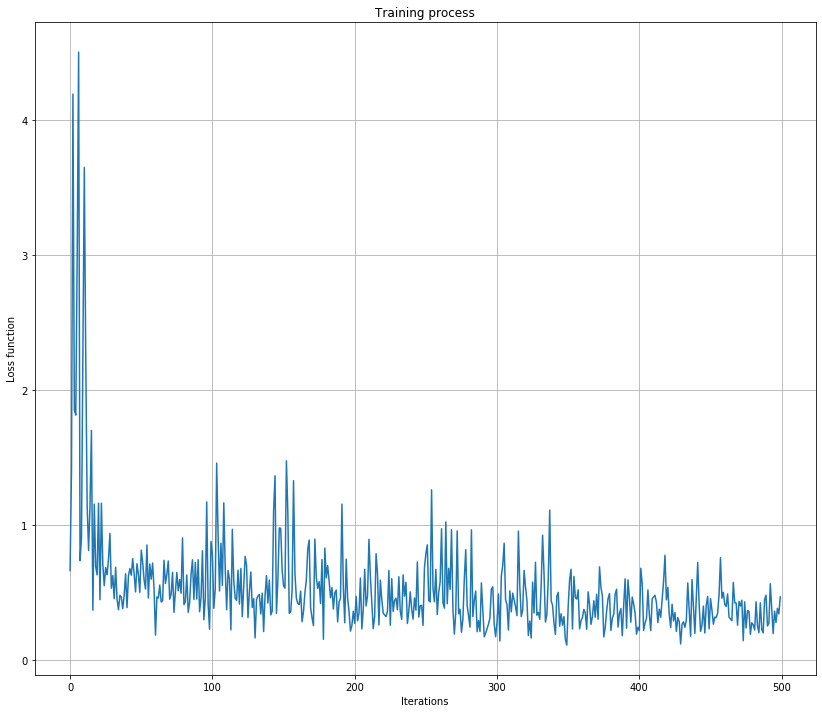

In [93]:
plot_loss(losses)

In [94]:
t_a = test_model(model, raw_test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:25<00:00, 30.69it/s]


Test accuracy: 0.86192


**shedule lr**

In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [0]:
def train_opt_model(model, train_iterator, valid_iterator, criterion, optimizer, epochs = 10, best_val_loss=10., scheduler=None, early=True):
  model = model.to(device)
  criterion = criterion.to(device)
  val_acc = []
  for n_epoch in range(epochs):
      
      train_losses = train_epoch(model, optimizer, criterion, train_iterator, n_epoch)
      
      mean_val_loss, acc = evaluate_epoch(model, criterion, valid_iterator)
      val_acc.append(acc)
      if scheduler:
        if type(scheduler) == tt.optim.lr_scheduler.ReduceLROnPlateau:
          scheduler.step(mean_val_loss)
        else:
          scheduler.step()
      print()
      print(f"Losses: train - {np.mean(train_losses):.3f}, validation - {mean_val_loss:.3f}")

      print(f"Validation accuracy - {acc:.3f}")
      if early:
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
        else:
            print("Early stopping")
            break
  return train_losses, val_acc

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(raw_TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

raw_train_iterator, raw_valid_iterator, raw_test_iterator = BucketIterator.splits(
    (raw_trn, raw_vld, raw_tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()
scheduler = tt.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [98]:
losses, val_acc = train_opt_model(model, raw_train_iterator, raw_valid_iterator, criterion, optimizer, scheduler=scheduler)

Epoch 2:   0%|          | 0/16000 [00:00<?, ?it/s]


Losses: train - 0.789, validation - 0.368
Validation accuracy - 0.879


Epoch 2: 100%|██████████| 16000/16000 [02:59<00:00, 86.10it/s, train_loss=0.216]



Losses: train - 0.216, validation - 0.922
Validation accuracy - 0.881
Early stopping


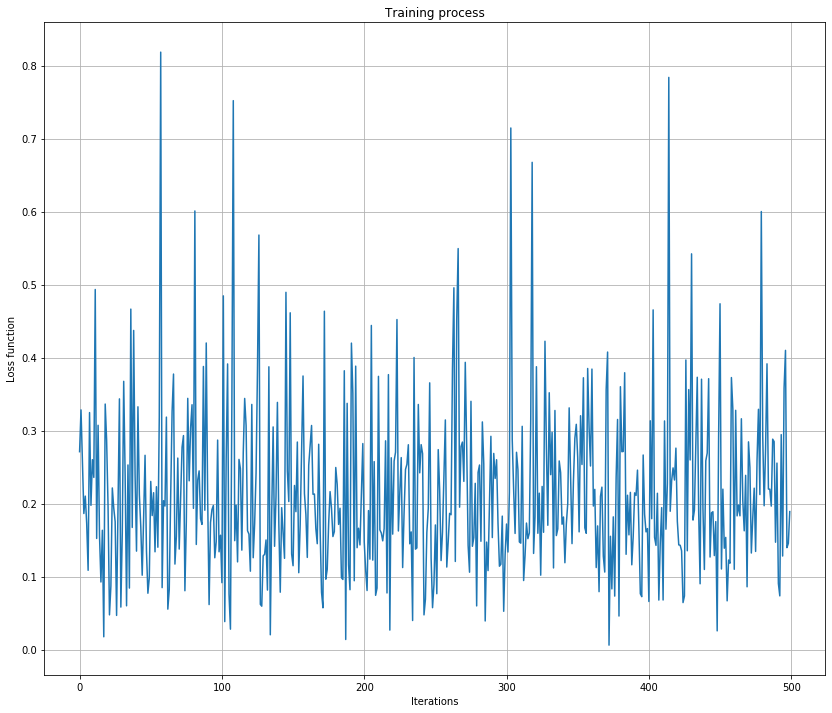

In [99]:
plot_loss(losses)

In [100]:
t_a = test_model(model, raw_test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:25<00:00, 31.05it/s]


Test accuracy: 0.86344


In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(raw_TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

raw_train_iterator, raw_valid_iterator, raw_test_iterator = BucketIterator.splits(
    (raw_trn, raw_vld, raw_tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = tt.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0125, max_lr=0.2, cycle_momentum=False)

In [102]:
losses, val_acc = train_opt_model(model, raw_train_iterator, raw_valid_iterator, criterion, optimizer, scheduler=scheduler)

Epoch 2:   0%|          | 0/16000 [00:00<?, ?it/s]


Losses: train - 0.567, validation - 0.597
Validation accuracy - 0.883


Epoch 2: 100%|██████████| 16000/16000 [03:01<00:00, 82.40it/s, train_loss=0.222]



Losses: train - 0.222, validation - 0.837
Validation accuracy - 0.882
Early stopping


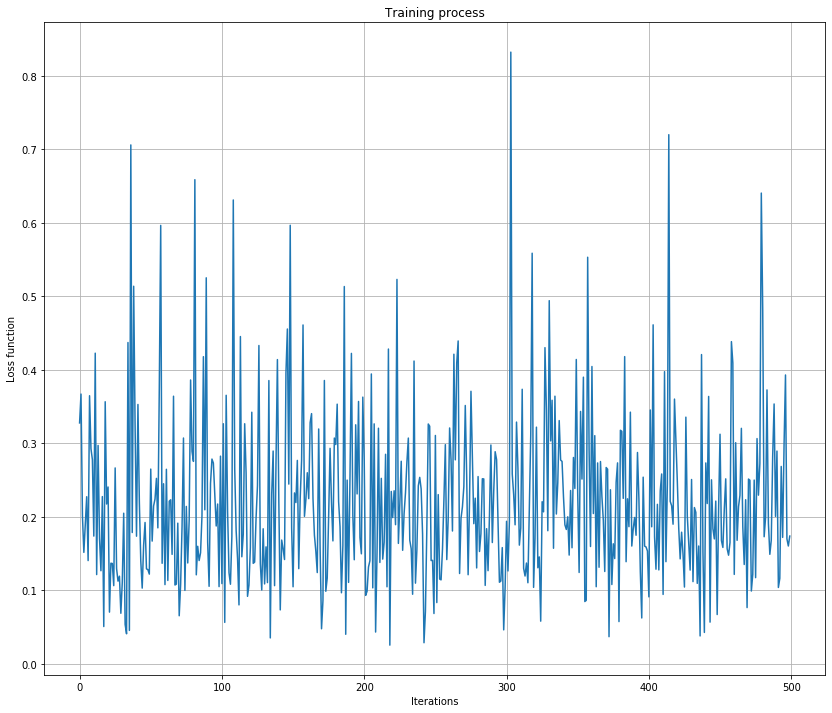

In [103]:
plot_loss(losses)

In [104]:
t_a = test_model(model, raw_test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:26<00:00, 29.94it/s]


Test accuracy: 0.8632


**Accuracy with one epoch, unlemmatized**

```
embed_size=100,
hidden_size=128,
kernels=[2,3,4,5]
batch_size=32
dropout_rate = 0.
```



In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(raw_TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

raw_train_iterator, raw_valid_iterator, raw_test_iterator = BucketIterator.splits(
    (raw_trn, raw_vld, raw_tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [107]:
losses, val_acc = train_my_model(model, raw_train_iterator, raw_valid_iterator, criterion, optimizer, epochs=1)

Epoch 1: 100%|██████████| 16000/16000 [03:04<00:00, 94.75it/s, train_loss=0.564] 



Losses: train - 0.564, validation - 0.486
Validation accuracy - 0.881


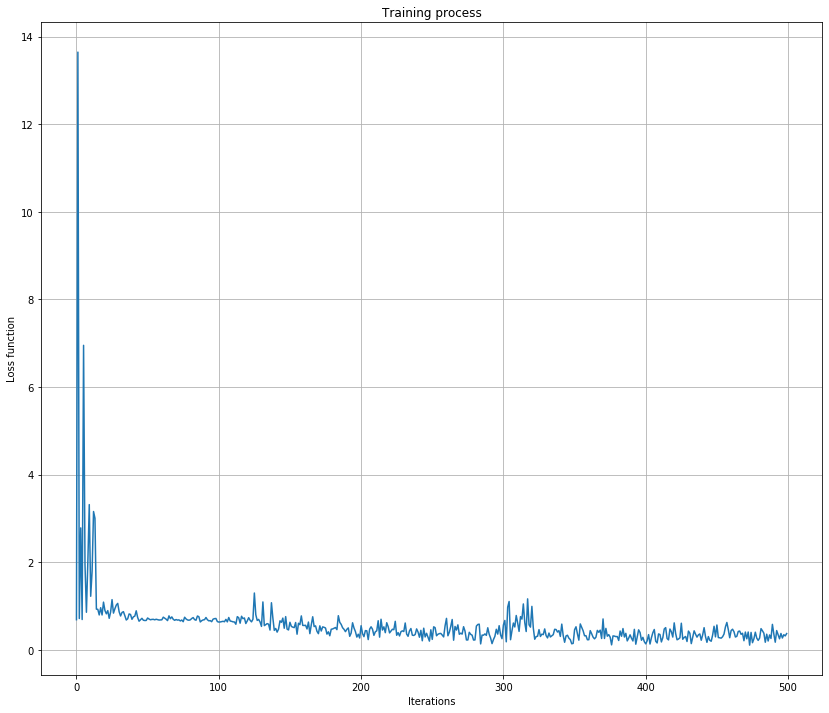

In [108]:
plot_loss(losses)

In [109]:
t_a = test_model(model, raw_test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:25<00:00, 31.03it/s]


Test accuracy: 0.87104


## THIS IS THE BEST RESULT: test acc = 0.871
parametrs: unlemmatized, 0.8 training data, embed_size=100, hidden_size=128, kernels=[2,3,4,5], batch_size=32, no dropout

**lemmatized**


In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [111]:
classes={
    'neg': -1,
    'pos': 1
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=lemmatizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

datafields = [('id', None), ('review', TEXT), ('label', LABEL)]

trn, tst = TabularDataset.splits(
               path=".", # the root directory where the data lies
               train='imdb_train.csv', test="imdb_test.csv",
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=datafields)

In [0]:
TEXT.build_vocab(trn, min_freq=10, vectors="glove.twitter.27B.100d")

In [0]:
LABEL.build_vocab(trn)

In [0]:
trn, vld = trn.split(0.8, stratified=True, random_state=np.random.seed(SEED))

**Accuracy with one epoch, lemmatized**

```
embed_size=100,
hidden_size=128,
kernels=[2,3,4,5]
batch_size=32
dropout_rate = 0.
```



In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (trn, vld, tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.0125)
criterion = nn.CrossEntropyLoss()

In [117]:
losses, val_acc = train_my_model(model, train_iterator, valid_iterator, criterion, optimizer, epochs=1)

Epoch 1: 100%|██████████| 20000/20000 [03:43<00:00, 98.91it/s, train_loss=0.454]



Losses: train - 0.586, validation - 0.613
Validation accuracy - 0.882


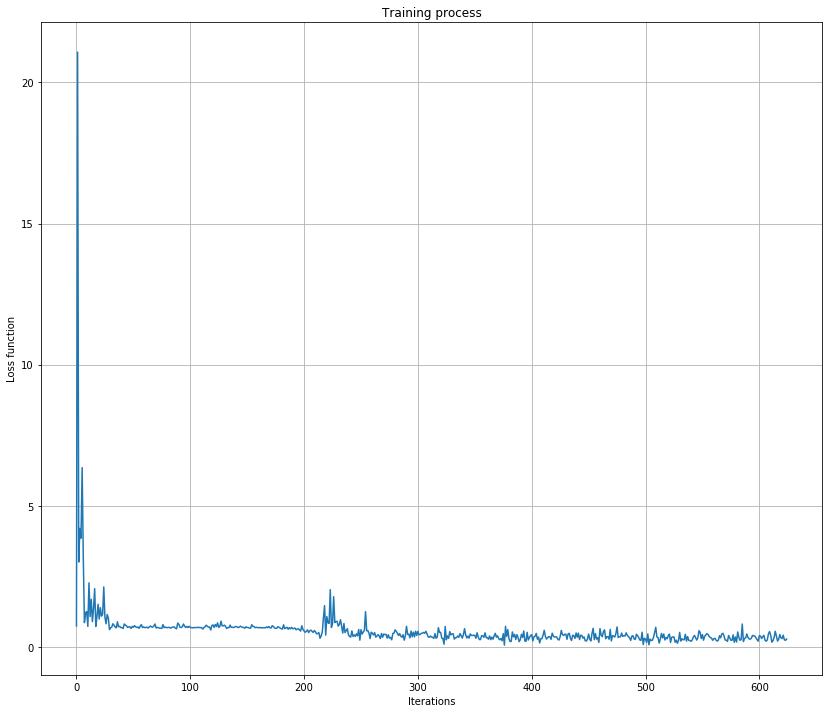

In [118]:
plot_loss(losses)

In [119]:
t_a = test_model(model, test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:25<00:00, 30.86it/s]


Test accuracy: 0.86344


**Accuracy with more epochs, lemmatized**

```
embed_size=100,
hidden_size=128,
kernels=[2,3,4,5]
batch_size=32
dropout_rate = 0.2
early stopping
```

In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (trn, vld, tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.0125)
criterion = nn.CrossEntropyLoss()

In [122]:
losses, val_acc = train_my_model(model, train_iterator, valid_iterator, criterion, optimizer)

Epoch 2:   0%|          | 0/20000 [00:00<?, ?it/s]


Losses: train - 0.515, validation - 0.724
Validation accuracy - 0.884


Epoch 2: 100%|██████████| 20000/20000 [03:42<00:00, 84.01it/s, train_loss=0.236]



Losses: train - 0.242, validation - 0.833
Validation accuracy - 0.883
Early stopping


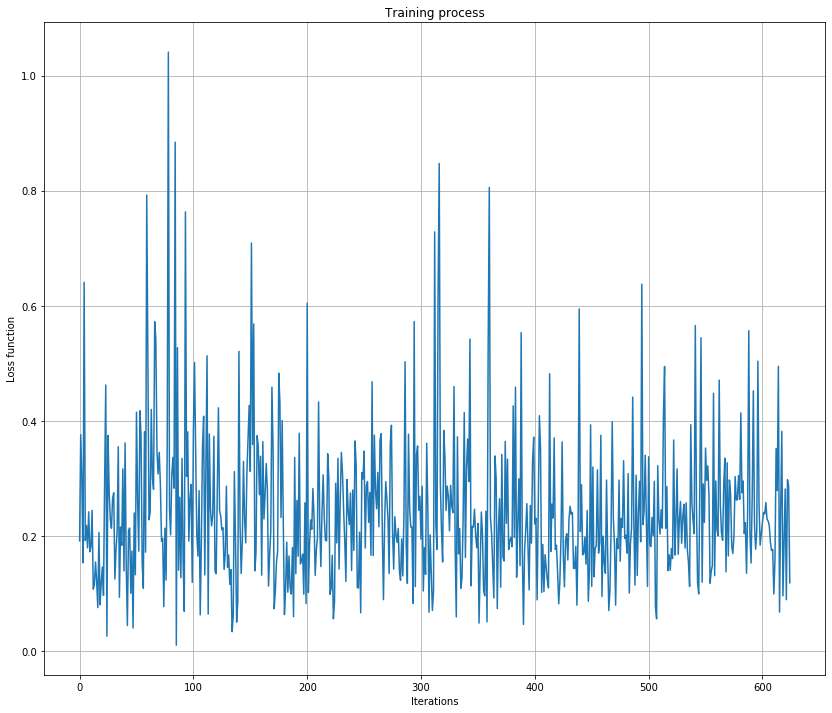

In [123]:
plot_loss(losses)

In [124]:
t_a = test_model(model, test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:25<00:00, 30.98it/s]


Test accuracy: 0.86664


**Accuracy with 10 epochs and 256 hidden size, lemmatized**
```
embed_size=100,
hidden_size=256,
kernels=[2,3,4,5]
batch_size=32
dropout_rate = 0.2
early stopping enabled
```


In [0]:
tt.cuda.empty_cache()

batch_size = 32

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=256,
                kernels=[2,3,4,5],
                dropout_rate=0.
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (trn, vld, tst),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review),
    device=device
)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [126]:
losses, val_acc = train_my_model(model, train_iterator, valid_iterator, criterion, optimizer, epochs=10)

Epoch 2:   0%|          | 0/20000 [00:00<?, ?it/s]


Losses: train - 0.615, validation - 0.599
Validation accuracy - 0.881


Epoch 2: 100%|██████████| 20000/20000 [06:13<00:00, 49.62it/s, train_loss=0.257]



Losses: train - 0.258, validation - 0.778
Validation accuracy - 0.885
Early stopping


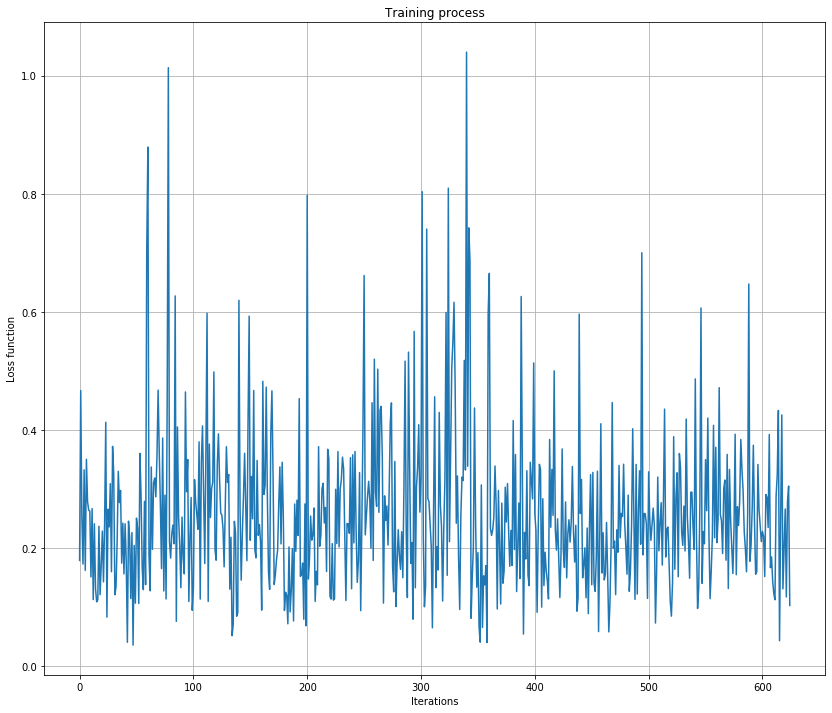

In [127]:
plot_loss(losses)

In [128]:
t_a = test_model(model, test_iterator)
print(f"\nTest accuracy: {np.mean(t_a)}")

test: 100%|██████████| 782/782 [00:42<00:00,  4.81it/s]


Test accuracy: 0.86828


In [0]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)